In [ ]:
# STEP 1: Install & Setup Kaggle API
!pip install -q kaggle

# Upload your kaggle.json file from your computer
from google.colab import files
files.upload()  # Upload kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"datascienceindee","key":"d4eeaea691189add08caa0cd27882526"}'}

In [ ]:
# STEP 2: Set up kaggle.json credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# STEP 3: Download and unzip the PlantVillage dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset
!unzip -q plantvillage-dataset.zip -d plantvillage


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [00:20<00:00, 221MB/s]
100% 2.04G/2.04G [00:20<00:00, 105MB/s]


In [4]:
# STEP 4: Set base path to 'color' folder only
base_dir = 'plantvillage/plantvillage dataset/color'

# Optional check
import os
print("Number of classes:", len(os.listdir(base_dir)))
print("Sample classes:", os.listdir(base_dir)[:5])


Number of classes: 38
Sample classes: ['Grape___Esca_(Black_Measles)', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Grape___Black_rot', 'Tomato___Bacterial_spot', 'Corn_(maize)___healthy']


In [5]:
# STEP 5: Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


In [6]:
# STEP 6: Prepare ImageDataGenerators
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% training, 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [7]:
# STEP 7: Build the CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,309,542 (12.62 MB)

 Trainable params: 3,309,542 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# STEP 7.5: Add EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)


In [9]:
# STEP 8: Train the model
EPOCHS = 7

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 241s 173ms/step - accuracy: 0.3132 - loss: 2.5894 - val_accuracy: 0.6710 - val_loss: 1.1549
Epoch 2/7
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 232s 171ms/step - accuracy: 0.5964 - loss: 1.3490 - val_accuracy: 0.8002 - val_loss: 0.6814
Epoch 3/7
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 232s 171ms/step - accuracy: 0.6759 - loss: 1.0602 - val_accuracy: 0.8341 - val_loss: 0.5591
Epoch 4/7
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 232s 170ms/step - accuracy: 0.7202 - loss: 0.9018 - val_accuracy: 0.8568 - val_loss: 0.4502
Epoch 5/7
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 232s 171ms/step - accuracy: 0.7501 - loss: 0.7964 - val_accuracy: 0.8640 - val_loss: 0.4222
Epoch 6/7
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 232s 171ms/step - accuracy: 0.7736 - loss: 0.7223 - val_accuracy: 0.8852 - val_loss: 0.3585
Epoch 7/7
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 232s 171ms/step - accuracy: 0.8061 - loss: 0.6076 - val_accuracy: 0.8934 - val_loss: 0.3260


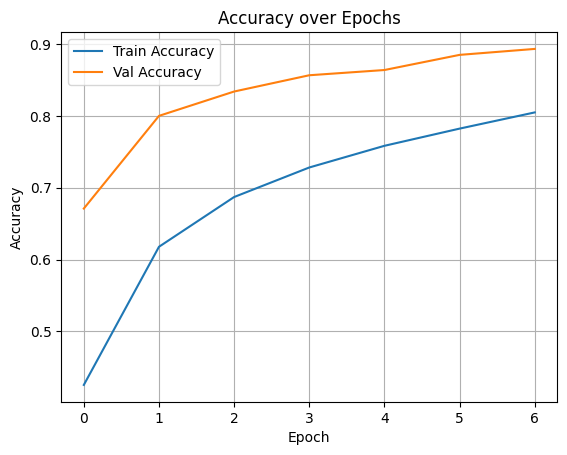

In [10]:
# STEP 9: Plot accuracy curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from google.colab import files
uploaded = files.upload()


Saving test_potato_early_blight.jpg to test_potato_early_blight.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


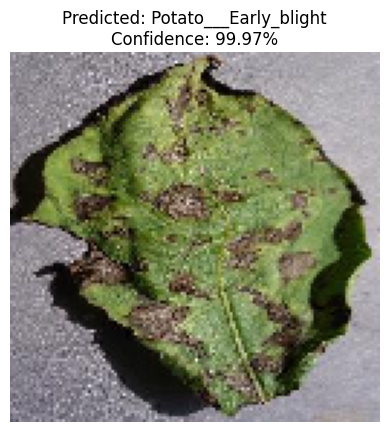

In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Set your image path
img_path = "test_potato_early_blight.jpg"

# Load and preprocess the image
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Predict using the model already in memory
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction)
predicted_class = list(train_data.class_indices.keys())[predicted_index]
confidence = prediction[0][predicted_index] * 100

# Show result
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}%')
plt.show()


In [15]:
model.save(os.path.join(save_dir, 'plant_disease_model.h5'))
print(f"TensorFlow/Keras model saved to: {os.path.join(save_dir, 'plant_disease_model.h5')}")

TensorFlow/Keras model saved to: /content/drive/MyDrive/Plant_Disease_Model/plant_disease_model.h5
